In [2]:
import gc
import hashlib
import json
import os
from collections import Counter
from typing import Callable, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import pickle as pk
import random

In [2]:
with open("../templates/metadata_w_examples.json") as f:
    metadatas = json.load(f)

In [3]:
def get_extension(s: str) -> str:
    return s.split(".")[-1]


template_directory = "../templates/template_data/"
example_directory = "../templates/template_examples/"

_X, _Y = [], []

templates = set(os.listdir(template_directory))
examples = set(os.listdir(example_directory))
for metadata in metadatas:
    template_file = metadata["html_file"] + "." + get_extension(metadata["src"])
    template_id = metadata["Template ID"]

    # Process template
    if template_file not in templates:
        raise Exception(f"CAN NOT FIND TEMPLATE: {template_file}")

    template_path = os.path.join(template_directory, template_file)
    _X.append(os.path.abspath(template_path))
    _Y.append(template_id)

    # Process examples
    for example in metadata["examples"]:
        byte_string = example["title"].encode()
        md5_hash = hashlib.md5(byte_string).hexdigest()
        ext = get_extension(example["url"])

        example_filename = f"{md5_hash}_{template_id}.{ext}"
        example_path = os.path.join(example_directory, example_filename)

        if example_filename not in examples:
            raise Exception(f"CAN NOT FIND EXAMPLE: {example_filename}")

        _X.append(os.path.abspath(example_path))
        _Y.append(template_id)


X_data, Y_data = np.array(_X), np.array([int(y) for y in _Y])

In [4]:
X_data.shape, Y_data.shape

((20584,), (20584,))

(5113,) (34,)


(array([3.09e+03, 4.57e+02, 2.66e+02, 2.02e+02, 1.23e+02, 1.23e+02,
        9.20e+01, 7.50e+01, 4.70e+01, 5.50e+01, 4.00e+01, 4.70e+01,
        1.12e+02, 2.98e+02, 1.50e+01, 7.00e+00, 7.00e+00, 8.00e+00,
        5.00e+00, 5.00e+00, 5.00e+00, 2.00e+00, 1.00e+00, 4.00e+00,
        1.00e+00, 3.00e+00, 4.00e+00, 1.00e+01, 3.00e+00, 2.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 2.00e+00]),
 array([ 1.        ,  2.02941176,  3.05882353,  4.08823529,  5.11764706,
         6.14705882,  7.17647059,  8.20588235,  9.23529412, 10.26470588,
        11.29411765, 12.32352941, 13.35294118, 14.38235294, 15.41176471,
        16.44117647, 17.47058824, 18.5       , 19.52941176, 20.55882353,
        21.58823529, 22.61764706, 23.64705882, 24.67647059, 25.70588235,
        26.73529412, 27.76470588, 28.79411765, 29.82352941, 30.85294118,
        31.88235294, 32.91176471, 33.94117647, 34.97058824, 36.        ]),
 <BarContainer object of 34 artists>)

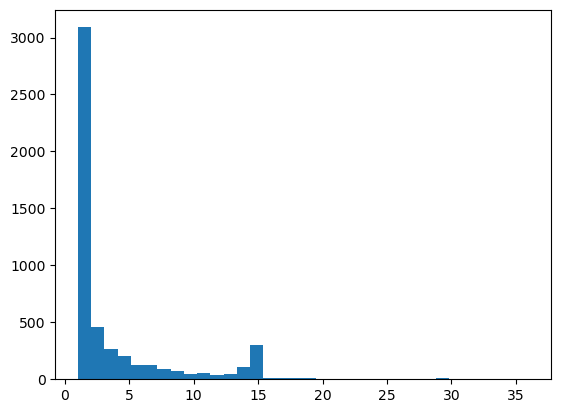

In [5]:
count = Counter(Y_data)
print(np.unique(Y_data).shape, np.unique(list(count.values())).shape)
plt.hist(count.values(), bins=34)

In [6]:
Counter([get_extension(i) for i in X_data])

Counter({'gif': 15471, 'mp4': 5113})

In [12]:
# data = [X_data, Y_data]
# with open("./data/data.pkl", "wb") as f:
#     pk.dump(data, f)

# Sample data so that dataset is more balance

In [29]:
with open("./data/data.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)
    
def sample(data: list, n: int = 40):
    res = []
    count = {}
    added_idx = set()
    
    for _ in range(len(data) * n):
        i = random.randint(0, len(data)-1)
        elem = data[i]
        
        if elem not in count and i not in added_idx:
            res.append(i)
            added_idx.add(i)
            count[elem] = 1
        else:
            if count[elem] > n or i in added_idx:
                continue
            else:
                res.append(i)
                added_idx.add(i)
                count[elem] += 1
    return res

def merge(data: list, n: int = 5):
    count = Counter(data)
    Y_merged = []
    for i in data:
        if count[i] < n:
            Y_merged.append(0)
        else:
            Y_merged.append(i)

    return np.array(Y_merged)

In [44]:
Y_merged = merge(Y_data, n=5)
idxes = sample(Y_merged)
Y_sampled = Y_merged[idxes]
X_sampled = X_data[idxes]
len(np.unique(Y_sampled)), len(Y_sampled), len(idxes), len(np.unique(idxes)), idxes

(1301,
 14185,
 14185,
 14185,
 [11833,
  17874,
  7584,
  13802,
  9317,
  8704,
  1058,
  4671,
  1152,
  15125,
  12400,
  20,
  7801,
  15337,
  9668,
  11463,
  759,
  17706,
  17851,
  14779,
  6449,
  12851,
  1707,
  4473,
  19226,
  9959,
  17262,
  601,
  4525,
  5224,
  12090,
  9001,
  13558,
  16001,
  14675,
  8757,
  9573,
  14084,
  3399,
  14216,
  19539,
  235,
  3044,
  512,
  671,
  13096,
  261,
  17367,
  12650,
  12603,
  1311,
  16690,
  130,
  1693,
  18738,
  16309,
  5221,
  20083,
  20110,
  2934,
  17611,
  4713,
  10486,
  10839,
  20421,
  19478,
  18923,
  10099,
  19914,
  9139,
  7101,
  12562,
  4656,
  8888,
  2579,
  8042,
  17788,
  5712,
  2250,
  4344,
  10739,
  6463,
  18581,
  10787,
  5018,
  1477,
  12575,
  7057,
  7394,
  9378,
  6878,
  13626,
  5213,
  17984,
  7087,
  4629,
  2450,
  19335,
  7455,
  20542,
  12811,
  1725,
  1642,
  6124,
  10936,
  2479,
  1408,
  12142,
  4902,
  5971,
  2468,
  3960,
  7821,
  1006,
  6623,
  16608,

(array([325., 215., 122.,  95.,  47., 410.,  22.,  15.,  10.,   5.,   3.,
          5.,   7.,  13.,   2.,   2.,   1.,   1.,   0.,   1.]),
 array([ 5. ,  6.8,  8.6, 10.4, 12.2, 14. , 15.8, 17.6, 19.4, 21.2, 23. ,
        24.8, 26.6, 28.4, 30.2, 32. , 33.8, 35.6, 37.4, 39.2, 41. ]),
 <BarContainer object of 20 artists>)

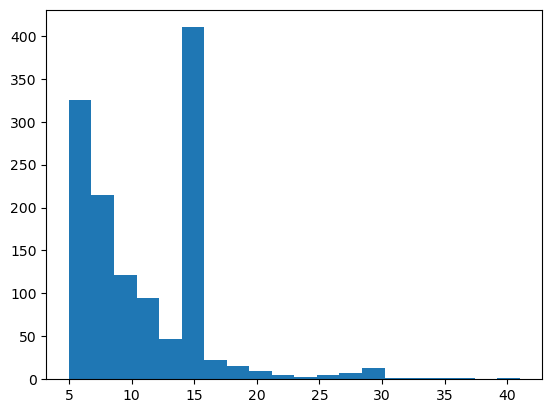

In [41]:
plt.hist(Counter(Y_sampled).values(), bins = 20)

In [52]:
for _ in range(10):
    test_idx = random.randint(0, len(Y_sampled)-1)
    print(X_sampled[test_idx][-20:], Y_sampled[test_idx])

6ce9b5_359641382.gif 359641382
547a10_372481469.gif 372481469
ee2fc8_395326114.gif 395326114
5f3b00_515132873.gif 515132873
c48c34_181464795.gif 181464795
engen-vs-Gyutaro.mp4 463156846
859ca4_346353985.gif 346353985
550a6c_171082049.gif 171082049
aaff48_415795572.gif 415795572
6f2926_292185822.gif 292185822


In [54]:
# data = [X_sampled, Y_sampled]
# with open("./data/data_sampled.pkl", "wb") as f:
#     pk.dump(data, f)

(40,) (40,) [306509753 370636203 416346667 418256352]


(array([12.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0., 18.]),
 array([3.06509753e+08, 3.17684413e+08, 3.28859073e+08, 3.40033733e+08,
        3.51208393e+08, 3.62383052e+08, 3.73557712e+08, 3.84732372e+08,
        3.95907032e+08, 4.07081692e+08, 4.18256352e+08]),
 <BarContainer object of 10 artists>)

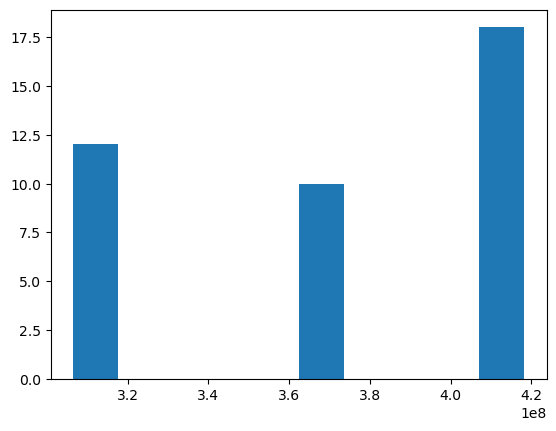

In [20]:
with open("./data/data_sampled.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

count = Counter(Y_data)
# print(count)

idxes = []
template_id = set([370636203, 306509753, 416346667, 418256352])
while len(idxes) < 40:
    idx = random.randint(0, len(Y_data)-1)
    if Y_data[idx] not in template_id:
        continue
        
    idxes.append(idx)

Y_smol = Y_data[idxes]
X_smol = X_data[idxes]
data = [X_smol, Y_smol]

print(X_smol.shape, Y_smol.shape, np.unique(Y_smol))
plt.hist(Y_smol)

In [21]:
# with open("./data/data_sampled_smol.pkl", "wb") as f:
#     pk.dump(data, f)